In [108]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm


# ======================================================================
# 1. Ken French 元ファイルから月次部分だけ抽出
# ======================================================================

def load_ff_monthly_from_ken_french(csv_path: str) -> pd.DataFrame:
    raw = pd.read_csv(csv_path, skiprows=4)

    num = pd.to_numeric(raw['Unnamed: 0'], errors='coerce')
    mask_monthly = num > 10000
    monthly = raw[mask_monthly].copy()

    monthly = monthly.rename(columns={'Unnamed: 0': 'date'})
    monthly['date'] = pd.to_datetime(monthly['date'].astype(int), format="%Y%m")
    monthly = monthly.set_index('date').sort_index()

    for col in ['Mkt-RF', 'RF']:
        monthly[col] = pd.to_numeric(monthly[col], errors='coerce')

    ff = monthly[['Mkt-RF', 'RF']].copy()
    ff['mkt_excess'] = ff['Mkt-RF'] / 100.0
    ff['rf'] = ff['RF'] / 100.0

    return ff[['mkt_excess', 'rf']].dropna()


# ======================================================================
# 2. 月タイプ分類
# ======================================================================

def classify_month_type(index):
    mt = pd.Series(index=index, dtype="object")
    for t in index:
        m = t.month % 3
        if m == 1:
            mt[t] = 'N'
        elif m == 2:
            mt[t] = 'R'
        else:
            mt[t] = '3'
    return mt


# ======================================================================
# 3. predictor z_t の構築
# ======================================================================

def build_predictor_z(ff):
    df = ff.copy()
    df["month_type"] = classify_month_type(df.index)

    df["mkt_lag"] = df["mkt_excess"].shift(1)
    df["mkt_mean_lag"] = df["mkt_excess"].expanding().mean().shift(1)
    df = df.dropna()

    z = []
    last_R_diff = None
    for t, row in df.iterrows():
        mt = row["month_type"]
        mean_t_minus1 = row["mkt_mean_lag"]
        if mt == "R":
            diff = row["mkt_lag"] - mean_t_minus1
            z_t = diff
            last_R_ret = row["mkt_excess"]
        elif mt == "N":
            if (last_R_ret is not None) and (not math.isnan(mean_t_minus1)):
                diff = last_R_ret - mean_t_minus1
                z_t = -diff
            else:
                z_t = 0.0
        else:  # mt == "3"
            # 3 ヶ月目: 論文同様ここではポジションを取らない
            z_t = 0.0
        z.append(z_t)
    df["z"] = z
    return df

# ======================================================================
# 4. タイミング戦略
# ======================================================================

def apply_timing_strategy(df, target_vol=0.05, max_leverage=3.0):
    out = df.copy()
    z = out["z"]

    weights = []
    sig_hist = []
    strat_excess = []
    strat_total = []
    mkt_total = []

    for i, t in enumerate(out.index):
        if i == 0:
            sigma = np.nan
            w = 0.0
        else:
            sigma = z.iloc[:i].std(ddof=1)
            if sigma is np.nan or sigma == 0:
                w = 0.0
            else:
                w = z.iloc[i] * target_vol / sigma
                w = float(np.clip(w, -max_leverage, max_leverage))

        weights.append(w)
        sig_hist.append(sigma)

        mkt = out.at[t, "mkt_excess"]
        rf = out.at[t, "rf"]
        se = w * mkt
        strat_excess.append(se)
        strat_total.append(rf + se)
        mkt_total.append(rf + mkt)

    out["w"] = weights
    out["sigma_z_hist"] = sig_hist
    out["strat_excess"] = strat_excess
    out["strat_total"] = strat_total
    out["mkt_total"] = mkt_total

    return out


# ======================================================================
# 5. 相関・回帰分析
# ======================================================================

def regression_summary(df):
    X = sm.add_constant(df["z"])
    y = df["mkt_excess"]
    model = sm.OLS(y, X).fit()
    return model.params["z"], model.tvalues["z"]


# ======================================================================
# 6. グラフ描画
# ======================================================================

def plot_results(df):
    strat_wealth = (1 + df["strat_excess"]).cumprod()
    mkt_wealth = (1 + df["mkt_total"]).cumprod()

    plt.figure(figsize=(14,5))
    plt.plot(strat_wealth, label="Strategy", linewidth=2)
    #plt.plot(mkt_wealth, label="Market", linewidth=2)
    plt.title("Cumulative Return (Strategy vs Market)")
    plt.legend()
    plt.show()



In [155]:
ff = load_ff_monthly_from_ken_french("F-F_Research_Data_Factors.csv")
ff = ff.loc["2020-01-01":]

In [156]:
df = build_predictor_z(ff)
df.head(12)

,mkt_excess,rf,month_type,mkt_lag,mkt_mean_lag,z
date,,,,,,
2020-02-01,-0.0815,0.0012,R,-0.0011,-0.001100,0.000000
2020-03-01,-0.1337,0.0012,3,-0.0815,-0.041300,0.000000
2020-04-01,0.1360,0.0000,N,-0.1337,-0.072100,0.009400
2020-05-01,0.0557,0.0001,R,0.1360,-0.020075,0.156075
2020-06-01,0.0245,0.0001,3,0.0557,-0.004920,0.000000
2020-07-01,0.0583,0.0001,N,0.0245,-0.000017,-0.055717
2020-08-01,0.0762,0.0001,R,0.0583,0.008314,0.049986
2020-09-01,-0.0364,0.0001,3,0.0762,0.016800,0.000000
2020-10-01,-0.0208,0.0001,N,-0.0364,0.010889,-0.065311


In [157]:
print("\n=== Correlation ===")
print("All:", df["z"].corr(df["mkt_excess"]))
print("N  :", df[df["month_type"]=="N"]["z"].corr(df[df["month_type"]=="N"]["mkt_excess"]))
print("R  :", df[df["month_type"]=="R"]["z"].corr(df[df["month_type"]=="R"]["mkt_excess"]))
print("3  :", df[df["month_type"]=="3"]["z"].corr(df[df["month_type"]=="3"]["mkt_excess"]))

print("\n=== Regression β, t-value (mkt ~ z) ===")
beta_all, t_all = regression_summary(df)
beta_N, t_N = regression_summary(df[df["month_type"]=="N"])
beta_R, t_R = regression_summary(df[df["month_type"]=="R"])
beta_3, t_3 = regression_summary(df[df["month_type"]=="3"])

print(f"ALL : β={beta_all:.4f}, t={t_all:.2f}")
print(f"N   : β={beta_N:.4f}, t={t_N:.2f}")
print(f"R   : β={beta_R:.4f}, t={t_R:.2f}")
print(f"3   : β={beta_3:.4f}, t={t_3:.2f}")


=== Correlation ===
All: -0.0503392122909292
N  : -0.053778283360443664
R  : -0.07266069940176326
3  : nan

=== Regression β, t-value (mkt ~ z) ===
ALL : β=-0.0649, t=-0.41
N   : β=-0.0667, t=-0.25
R   : β=-0.0620, t=-0.33
3   : β=0.0000, t=nan


In [158]:
df = apply_timing_strategy(df)

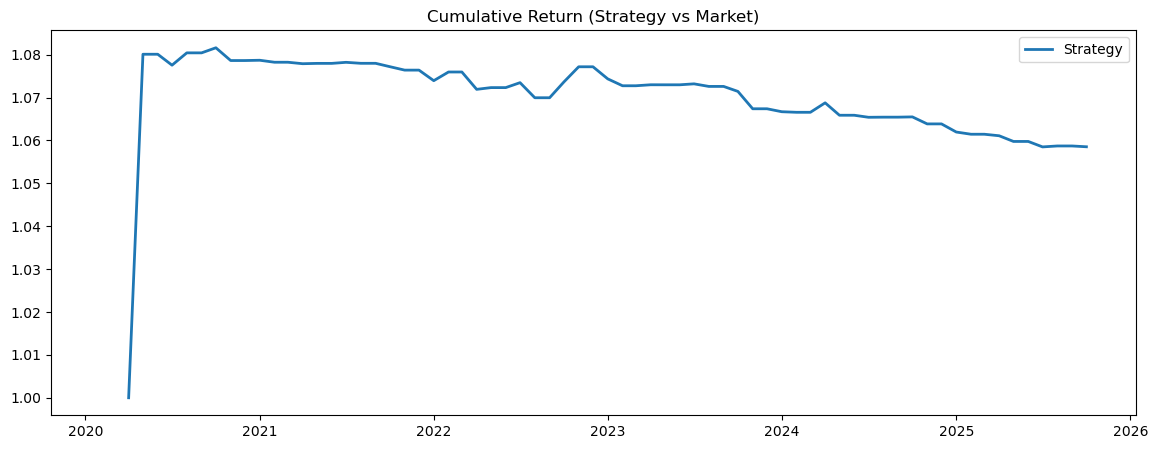

In [159]:
plot_results(df)

In [160]:
def add_nr_and_nm4(ff: pd.DataFrame) -> pd.DataFrame:
    """
    ff: load_ff_monthly_from_ken_french の出力
        必須列: ['mkt_excess', 'rf']

    追加される列:
        - 'month_type' : 'N', 'R', '3'
        - 'In_t'       : その月が newsy (N) なら 1, それ以外 0
        - 'nr_date'    : nr(t) に対応する日付
        - 'mkt_nr'     : mkt_excess[nr(t)]
        - 'mkt_nm1'..'mkt_nm4' : 直近 j 番目の newsy 月のリターン
        - 'mkt_nm4_avg': 直近4つの newsy 月の平均 (Guo 2025 P4_j mkt_nm(t,j))
    """
    df = ff.copy()
    df["month_type"] = classify_month_type(df.index)
    df["In_t"] = (df["month_type"] == "N").astype(int)

    dates = list(df.index)
    mt = df["month_type"].values
    mkt = df["mkt_excess"].values

    nr_dates = []
    mkt_nr_list = []

    # nm(t,j) 用に「これまで出てきた newsy 月の index」を蓄積
    past_newsy_indices = []

    mkt_nm1 = []
    mkt_nm2 = []
    mkt_nm3 = []
    mkt_nm4 = []

    for i, t in enumerate(dates):
        # ---- nr(t): t より前で最も近い N or R ----
        nr_idx = None
        j = i - 1
        while j >= 0:
            if mt[j] in ("N", "R"):
                nr_idx = j
                break
            j -= 1
        if nr_idx is None:
            nr_dates.append(None)
            mkt_nr_list.append(np.nan)
        else:
            nr_dates.append(dates[nr_idx])
            mkt_nr_list.append(mkt[nr_idx])

        # ---- newsy 月の履歴更新 ----
        if mt[i] == "N":
            past_newsy_indices.append(i)

        # ---- nm(t,j): 直近 newsy 月たち ----
        # t 自身は除きたいので、i より小さいインデックスのみ使用
        candidate_newsy = [k for k in past_newsy_indices if k < i]
        candidate_newsy_sorted = sorted(candidate_newsy, reverse=True)

        vals = []
        for jj in range(4):
            if jj < len(candidate_newsy_sorted):
                vals.append(mkt[candidate_newsy_sorted[jj]])
            else:
                vals.append(np.nan)

        mkt_nm1.append(vals[0])
        mkt_nm2.append(vals[1])
        mkt_nm3.append(vals[2])
        mkt_nm4.append(vals[3])

    df["nr_date"] = nr_dates
    df["mkt_nr"] = mkt_nr_list
    df["mkt_nm1"] = mkt_nm1
    df["mkt_nm2"] = mkt_nm2
    df["mkt_nm3"] = mkt_nm3
    df["mkt_nm4"] = mkt_nm4

    # 直近4つの newsy 月の平均（4つ揃っていない場合は NaN）
    df["mkt_nm4_avg"] = df[["mkt_nm1", "mkt_nm2", "mkt_nm3", "mkt_nm4"]].mean(axis=1)

    return df

def run_two_predictor_regression(df: pd.DataFrame):
    """
    Guo & Wachter Table 11, col (3) に対応する回帰:
    mkt_t = α + β1 mkt_nr(t)
              + β2 mkt_nr(t) * In_t
              + β3 mkt_nm4_avg(t)
              + β4 mkt_nm4_avg(t) * In_t
              + γ In_t + ε_t

    戻り値:
        statsmodels の結果オブジェクト (res) と
        β1..β4, γ を辞書で返す
    """
    # 説明変数が揃っているサンプルだけを使う
    reg_df = df[["mkt_excess", "mkt_nr", "mkt_nm4_avg", "In_t"]].dropna().copy()

    reg_df["x1"] = reg_df["mkt_nr"]
    reg_df["x2"] = reg_df["mkt_nr"] * reg_df["In_t"]
    reg_df["x3"] = reg_df["mkt_nm4_avg"]
    reg_df["x4"] = reg_df["mkt_nm4_avg"] * reg_df["In_t"]
    reg_df["x5"] = reg_df["In_t"]

    X = sm.add_constant(reg_df[["x1", "x2", "x3", "x4", "x5"]])
    y = reg_df["mkt_excess"]

    model = sm.OLS(y, X)
    res = model.fit(cov_type="HC0")  # White s.e.

    params = res.params
    tvals = res.tvalues

    out = {
        "alpha": (params["const"], tvals["const"]),
        "beta1_mktnr": (params["x1"], tvals["x1"]),
        "beta2_mktnr_In": (params["x2"], tvals["x2"]),
        "beta3_nm4": (params["x3"], tvals["x3"]),
        "beta4_nm4_In": (params["x4"], tvals["x4"]),
        "gamma_In": (params["x5"], tvals["x5"]),
    }
    return res, out



In [161]:
#ff = load_ff_monthly_from_ken_french("F-F_Research_Data_Factors.csv")
df_nr_nm = add_nr_and_nm4(ff)
df_nr_nm

,mkt_excess,rf,month_type,In_t,nr_date,mkt_nr,mkt_nm1,mkt_nm2,mkt_nm3,mkt_nm4,mkt_nm4_avg
date,,,,,,,,,,,
2020-01-01,-0.0011,0.0013,N,1,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,-0.0815,0.0012,R,0,2020-01-01,-0.0011,-0.0011,NaN,NaN,NaN,-0.00110
2020-03-01,-0.1337,0.0012,3,0,2020-02-01,-0.0815,-0.0011,NaN,NaN,NaN,-0.00110
2020-04-01,0.1360,0.0000,N,1,2020-02-01,-0.0815,-0.0011,NaN,NaN,NaN,-0.00110
2020-05-01,0.0557,0.0001,R,0,2020-04-01,0.1360,0.1360,-0.0011,NaN,NaN,0.06745
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-01,0.0486,0.0034,3,0,2025-05-01,0.0606,-0.0084,0.0280,-0.010,0.0122,0.00545
2025-07-01,0.0198,0.0034,N,1,2025-05-01,0.0606,-0.0084,0.0280,-0.010,0.0122,0.00545
2025-08-01,0.0184,0.0038,R,0,2025-07-01,0.0198,0.0198,-0.0084,0.028,-0.0100,0.00735


In [162]:
res, out = run_two_predictor_regression(df_nr_nm)
print(res.summary())  # 全体サマリ
print("\nCoefficients (value, t-stat):")
for name, (coef, tval) in out.items():
    print(f"{name:15s}: {coef: .4f},  t = {tval: .2f}")

                            OLS Regression Results                            
Dep. Variable:             mkt_excess   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.261
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.292
Time:                        14:50:50   Log-Likelihood:                 109.25
No. Observations:                  69   AIC:                            -206.5
Df Residuals:                      63   BIC:                            -193.1
Df Model:                           5                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.010     -0.376      0.7

In [146]:
# ======================================================================
# Guo&Wachter / Guo 2025 に基づく z*_t の構築
# ======================================================================

def build_z_star(
    df_nr_nm: pd.DataFrame,
    w_nr_R: float = 0.2,
    w_P4_R: float = 1.0,
    w_nr_N: float = -1.0,
    w_P4_N: float = -1.0,
) -> pd.DataFrame:
    """
    df_nr_nm:
        add_nr_and_nm4(ff) を通した DataFrame
        ['mkt_excess', 'month_type', 'mkt_nr', 'mkt_nm4_avg'] 等を含む。

    w_*:
        Guo&Wachter の回帰係数から決めた相対重み。
        デフォルト値は beta1, beta3, beta1+beta2, beta3+beta4 の符号と
        大きさをざっくり反映した設定。

    戻り値:
        df: 以下の列を追加
            - 'nr_demeaned' : mkt_nr - 平均(mkt_nr, 〜t-1)
            - 'P4_demeaned' : mkt_nm4_avg - 平均(P4, 〜t-1)
            - 'z_star'      : 月タイプ別ルールで合成された最終 predictor
    """
    df = df_nr_nm.copy()

    # nr(t), P4(t) が存在するところだけ使う
    df["nr_demeaned"] = (
        df["mkt_nr"] - df["mkt_nr"].expanding().mean().shift(1)
    )
    df["P4_demeaned"] = (
        df["mkt_nm4_avg"] - df["mkt_nm4_avg"].expanding().mean().shift(1)
    )

    z_star = []

    for t, row in df.iterrows():
        mt = row["month_type"]
        nr_d = row["nr_demeaned"]
        P4_d = row["P4_demeaned"]

        # 初期 NaN の扱い
        if np.isnan(nr_d) or np.isnan(P4_d):
            z_star.append(0.0)
            continue

        if mt == "R":
            # R 月: 順張り → nr, P4 に正の重み
            z_t = w_nr_R * nr_d + w_P4_R * P4_d
        elif mt == "N":
            # N 月: 逆張り → nr, P4 を符号反転（w_nr_N, w_P4_N は負）
            z_t = w_nr_N * nr_d + w_P4_N * P4_d
        else:  # mt == "3"
            # 3 ヶ月目はポジションを取らない
            z_t = 0.0

        z_star.append(z_t)

    df["z_star"] = z_star
    return df


In [147]:
# 3. Guo&Wachter + Guo(2025) に基づく z*_t を構築
df_zstar = build_z_star(
    df_nr_nm,
    w_nr_R=0.2,   # R 月の nr に対する重み
    w_P4_R=1.0,   # R 月の P4 に対する重み（順張り成分の主役）
    w_nr_N=-1.0,  # N 月の nr（逆張り）
    w_P4_N=-1.0,  # N 月の P4（逆張り）
)

# 4. タイミング戦略に渡すために列名 'z' を差し替え
df_for_strategy = df_zstar.copy()
df_for_strategy["z"] = df_for_strategy["z_star"]

# 5. 既存の apply_timing_strategy で運用
df_strat = apply_timing_strategy(
    df_for_strategy,
    target_vol=0.05,
    max_leverage=3.0,
)

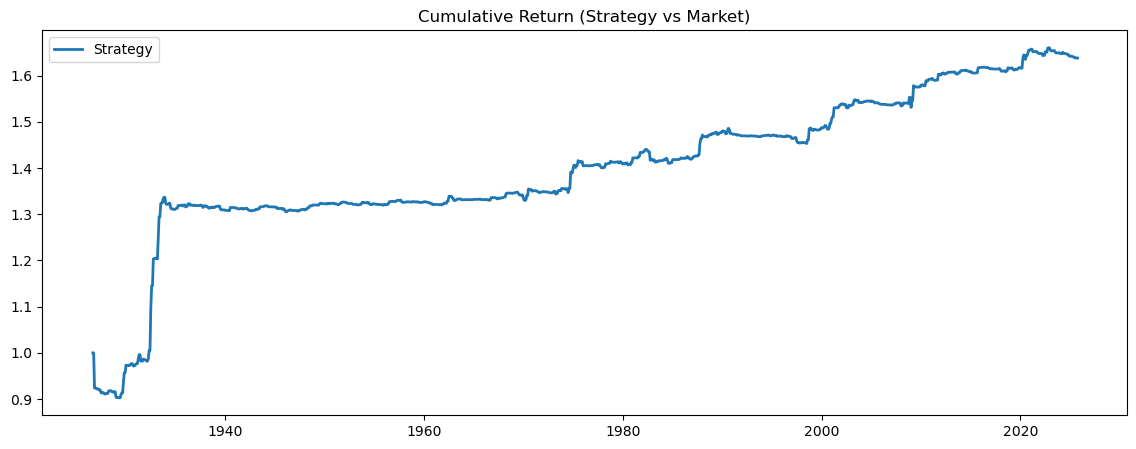

In [148]:
plot_results(df_strat)

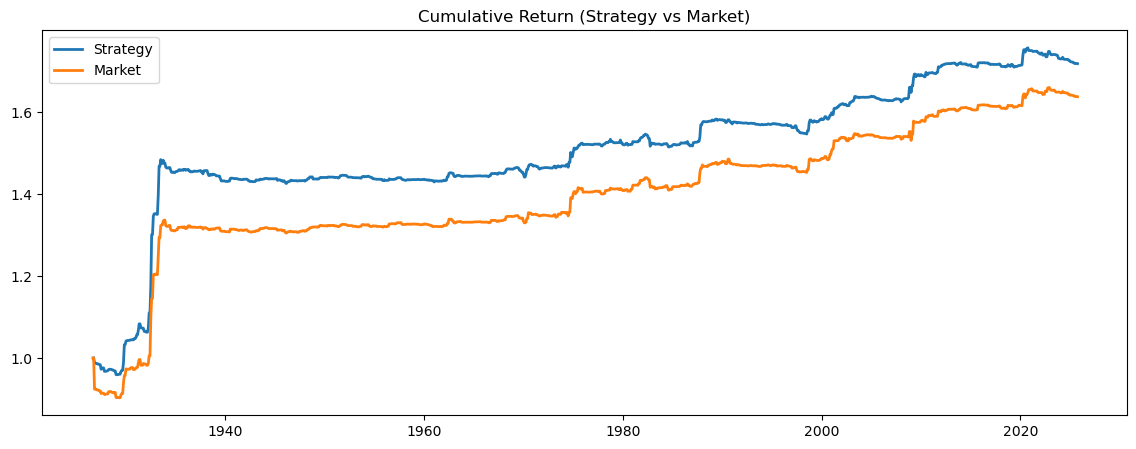

In [149]:
strat_wealth = (1 + df["strat_excess"]).cumprod()
strat_star_wealth = (1 + df_strat["strat_excess"]).cumprod()

plt.figure(figsize=(14,5))
plt.plot(strat_wealth, label="Strategy", linewidth=2)
plt.plot(strat_star_wealth, label="Market", linewidth=2)
plt.title("Cumulative Return (Strategy vs Market)")
plt.legend()
plt.show()

In [150]:
def prepare_predictors_for_dynamic(df_nr_nm: pd.DataFrame) -> pd.DataFrame:
    """
    add_nr_and_nm4(ff) を通した df に、
    nr_demeaned, P4_demeaned, prev_month_type を追加する。
    """
    df = df_nr_nm.copy()

    # nr(t), P4(t) の平均控除（〜t-1 までの平均を引く）
    df["nr_demeaned"] = df["mkt_nr"] - df["mkt_nr"].expanding().mean().shift(1)
    df["P4_demeaned"] = df["mkt_nm4_avg"] - df["mkt_nm4_avg"].expanding().mean().shift(1)

    # 前月の month_type
    df["prev_month_type"] = df["month_type"].shift(1)

    return df

def expected_sign_for_pair(prev_type: str, curr_type: str, predictor: str):
    """
    Guo&Wachter 的に期待される符号を返す。
    戻り値: +1, -1, 0 （0は「符号制約なし」）
    predictor: "nr_demeaned" or "P4_demeaned"
    """
    # ベースは nr も P4 も同じパターンで扱う
    if prev_type == "N" and curr_type == "R":
        # continuation: 正の予測
        return +1
    if prev_type == "R" and curr_type == "N":
        # reversal: 負の予測
        return -1

    # 他のペアは符号制約なし（0を返す）
    return 0

import statsmodels.api as sm
import numpy as np
import math

def build_dynamic_z_pair_screening(
    df_nr_nm: pd.DataFrame,
    lookback_years: int = 20,
    min_obs: int = 60,
    t_threshold: float = 1.96,
    use_expected_sign: bool = True,
    weight_mode: str = "sign",
) -> pd.DataFrame:
    """
    df_nr_nm:
        add_nr_and_nm4(ff) → prepare_predictors_for_dynamic(df_nr_nm) を通した DataFrame
        必須列:
            - 'mkt_excess'
            - 'month_type'
            - 'prev_month_type'
            - 'nr_demeaned'
            - 'P4_demeaned'

    lookback_years:
        回帰に使うローリング窓の長さ（年）。
        None の場合は expanding（開始〜t-1 全部）。

    min_obs:
        各 pair×predictor の回帰に必要な最小観測数（月）。

    t_threshold:
        |t| >= この値 で「有意」と判断。

    use_expected_sign:
        True の場合、expected_sign_for_pair による符号制約も課す。

    weight_mode:
        "sign": z_t は「beta の符号 × predictor の値」の合計
        "beta": z_t は「beta × predictor の値」の合計（より回帰係数に忠実）

    戻り値:
        df: 新たに 'z_dynamic' 列を追加。
             これはオンラインでスクリーニングされた最終予測子。
    """
    df = df_nr_nm.copy()

    dates = df.index
    valid_mask = df[["mkt_excess", "month_type", "prev_month_type",
                     "nr_demeaned", "P4_demeaned"]].notna().all(axis=1)

    z_dynamic = []

    # ログ用に必要なら記録（ここではβとtの履歴は省略、必要なら追加可）
    for i, t in enumerate(dates):
        if not valid_mask.loc[t]:
            z_dynamic.append(0.0)
            continue

        curr_type = df.at[t, "month_type"]
        prev_type = df.at[t, "prev_month_type"]

        # prev_type が NaN（最初の月など）の場合はポジションを取らない
        if isinstance(prev_type, float) and math.isnan(prev_type):
            z_dynamic.append(0.0)
            continue

        # t より前だけを使う
        past_mask = (dates < t) & valid_mask

        if lookback_years is not None:
            start_date = t - pd.DateOffset(years=lookback_years)
            past_mask &= (dates >= start_date)

        past_df = df.loc[past_mask]

        if past_df.empty:
            z_dynamic.append(0.0)
            continue

        # この日の pair に対応するサンプルだけを抽出
        pair_df = past_df[
            (past_df["month_type"] == curr_type) &
            (past_df["prev_month_type"] == prev_type)
        ]

        if len(pair_df) < min_obs:
            # サンプルが少なすぎる pair は無効
            z_dynamic.append(0.0)
            continue

        # この pair でどの predictor が「今も有効か」を判定
        pred_names = ["nr_demeaned", "P4_demeaned"]
        active_contribs = []

        for pred in pred_names:
            X = sm.add_constant(pair_df[pred])
            y = pair_df["mkt_excess"]
            model = sm.OLS(y, X).fit()

            beta = model.params[pred]
            tval = model.tvalues[pred]

            if np.isnan(beta) or np.isnan(tval):
                continue

            # t値による有意性チェック
            if abs(tval) < t_threshold:
                continue

            # 符号制約チェック
            if use_expected_sign:
                esign = expected_sign_for_pair(prev_type, curr_type, pred)
                if esign != 0 and np.sign(beta) != np.sign(esign):
                    # 理論と逆の符号なら捨てる
                    continue

            # 有効 predictor として採用
            x_t = df.at[t, pred]

            if weight_mode == "beta":
                contrib = beta * x_t
            else:  # "sign"
                contrib = np.sign(beta) * x_t

            active_contribs.append(contrib)

        if active_contribs:
            z_t = float(np.sum(active_contribs))
        else:
            z_t = 0.0

        z_dynamic.append(z_t)

    df["z_dynamic"] = z_dynamic
    return df


In [151]:
df_prep = prepare_predictors_for_dynamic(df_nr_nm)

# 4. オンライン・ペアスクリーニングで z_dynamic を構築
df_dyn = build_dynamic_z_pair_screening(
    df_prep,
    lookback_years=20,   # 直近20年だけで予測力を評価
    min_obs=60,          # pair×predictor に最低60観測
    t_threshold=1.96,    # 5% 水準
    use_expected_sign=True,
    weight_mode="sign",  # beta の符号で重み付け
)

In [152]:
df_dyn

,mkt_excess,rf,month_type,In_t,nr_date,mkt_nr,mkt_nm1,mkt_nm2,mkt_nm3,mkt_nm4,mkt_nm4_avg,nr_demeaned,P4_demeaned,prev_month_type,z_dynamic
date,,,,,,,,,,,,,,,
1926-07-01,0.0289,0.0022,N,1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0
1926-08-01,0.0264,0.0025,R,0,1926-07-01,0.0289,0.0289,NaN,NaN,NaN,0.02890,NaN,NaN,N,0.0
1926-09-01,0.0038,0.0023,3,0,1926-08-01,0.0264,0.0289,NaN,NaN,NaN,0.02890,-0.002500,0.000000,R,0.0
1926-10-01,-0.0327,0.0032,N,1,1926-08-01,0.0264,0.0289,NaN,NaN,NaN,0.02890,-0.001250,0.000000,3,0.0
1926-11-01,0.0254,0.0031,R,0,1926-10-01,-0.0327,-0.0327,0.0289,NaN,NaN,-0.00190,-0.059933,-0.030800,N,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-01,0.0486,0.0034,3,0,2025-05-01,0.0606,-0.0084,0.0280,-0.010,0.0122,0.00545,0.052364,-0.004176,R,0.0
2025-07-01,0.0198,0.0034,N,1,2025-05-01,0.0606,-0.0084,0.0280,-0.010,0.0122,0.00545,0.052320,-0.004173,3,0.0
2025-08-01,0.0184,0.0038,R,0,2025-07-01,0.0198,0.0198,-0.0084,0.028,-0.0100,0.00735,0.011476,-0.002269,N,0.0


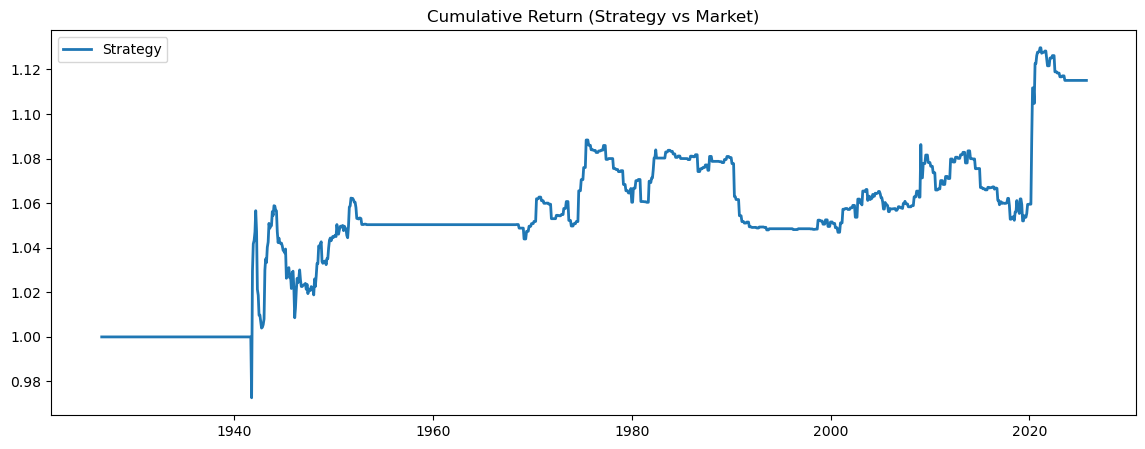

In [153]:
df_dyn_for_strat = df_dyn.copy()
df_dyn_for_strat["z"] = df_dyn_for_strat["z_dynamic"]

df_strat_2020 = apply_timing_strategy(
    df_dyn_for_strat,
    target_vol=0.05,
    max_leverage=3.0,
)

plot_results(df_strat_2020)

In [154]:
df_dyn_for_strat

,mkt_excess,rf,month_type,In_t,nr_date,mkt_nr,mkt_nm1,mkt_nm2,mkt_nm3,mkt_nm4,mkt_nm4_avg,nr_demeaned,P4_demeaned,prev_month_type,z_dynamic,z
date,,,,,,,,,,,,,,,,
1926-07-01,0.0289,0.0022,N,1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,0.0
1926-08-01,0.0264,0.0025,R,0,1926-07-01,0.0289,0.0289,NaN,NaN,NaN,0.02890,NaN,NaN,N,0.0,0.0
1926-09-01,0.0038,0.0023,3,0,1926-08-01,0.0264,0.0289,NaN,NaN,NaN,0.02890,-0.002500,0.000000,R,0.0,0.0
1926-10-01,-0.0327,0.0032,N,1,1926-08-01,0.0264,0.0289,NaN,NaN,NaN,0.02890,-0.001250,0.000000,3,0.0,0.0
1926-11-01,0.0254,0.0031,R,0,1926-10-01,-0.0327,-0.0327,0.0289,NaN,NaN,-0.00190,-0.059933,-0.030800,N,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-01,0.0486,0.0034,3,0,2025-05-01,0.0606,-0.0084,0.0280,-0.010,0.0122,0.00545,0.052364,-0.004176,R,0.0,0.0
2025-07-01,0.0198,0.0034,N,1,2025-05-01,0.0606,-0.0084,0.0280,-0.010,0.0122,0.00545,0.052320,-0.004173,3,0.0,0.0
2025-08-01,0.0184,0.0038,R,0,2025-07-01,0.0198,0.0198,-0.0084,0.028,-0.0100,0.00735,0.011476,-0.002269,N,0.0,0.0
